# Model testing

In [21]:
import sys
import os

cur_dir = os.getcwd()
root_dir = os.path.dirname(cur_dir+"/../../")
sys.path.append(root_dir)

In [22]:
# import the necessary packages
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import json

from src.data.load_data import load_data
from src.features.labeling import label_encode, one_hot_encode, label_and_one_hot_encode
from src.features.selection import select_features
from src.data.data_scaling import standardize_data, normalize_data
from src.data.split_data import split_data
from src.models.Logistic import train_Logistic
from src.models.NN import train_NN
from src.models.evaluate import evaluate_model
from src.evaluation.PerformanceMetrics import plot_roc, metrics, optimal_threshold


In [23]:
# load the dataset
df_wo = load_data()
df_w = load_data(weight=True)

In [24]:
# label encode readmitted column
df_wo = label_encode(df_wo, "readmitted", {'NO': 0, '>30': 1, '<30': 1})

# one hot encode the categorical columns
df_wo = one_hot_encode(df_wo)

/home/hasi/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [25]:
# split the data into train and test
X_train_wo, X_test_wo, y_train_wo, y_test_wo = split_data(df_wo, "readmitted")

In [26]:
# standardize the data
X_train_wo, X_test_wo = standardize_data(X_train_wo), standardize_data(X_test_wo)

--------------------
Data Standardized
--------------------
--------------------
Data Standardized
--------------------


In [7]:
X_train_wo

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_Asian,race_Caucasian,...,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_Steady,metformin-pioglitazone_Steady,change_No,diabetesMed_Yes
97610,0.201288,1.214665,-0.200407,0.859275,0.493307,0.868943,0.292293,0.815832,0,1,...,1,1,0,0,0,0,0,0,0,1
81915,1.205509,0.808560,-0.200407,0.859275,-0.289261,-0.212054,-0.504164,-0.219413,0,1,...,1,1,0,0,0,0,0,0,0,1
46771,-0.802933,-0.460519,-0.786121,-1.717249,-0.289261,-0.212054,-0.504164,-2.289904,0,1,...,0,1,0,0,0,0,0,0,1,1
30433,1.874990,0.300928,-0.786121,0.245817,-0.289261,-0.212054,-0.504164,0.815832,0,0,...,0,1,0,0,0,0,0,0,1,0
2635,-0.468193,0.047112,-0.786121,-0.490332,-0.289261,-0.212054,-0.504164,-0.219413,0,1,...,0,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91064,-0.802933,-0.663572,-0.200407,-1.594557,-0.289261,-0.212054,-0.504164,0.815832,0,1,...,0,1,0,0,0,0,0,0,1,0
17122,0.201288,0.453218,1.556735,-0.122258,-0.289261,-0.212054,-0.504164,-2.807526,0,1,...,0,1,0,0,0,0,0,0,1,1
64837,-1.137674,0.605507,-0.786121,-0.613024,-0.289261,-0.212054,-0.504164,-1.772281,0,1,...,0,1,0,0,0,0,0,0,1,0
60903,-0.802933,1.570007,0.385307,-0.122258,-0.289261,-0.212054,-0.504164,0.815832,0,1,...,1,1,0,0,0,0,0,0,0,1


In [21]:
y_train_wo

97610    0
81915    0
46771    0
30433    0
2635     1
        ..
91064    1
17122    0
64837    1
60903    1
23380    0
Name: readmitted, Length: 71236, dtype: int64

# Neural Network

In [30]:
tf.keras.backend.clear_session()

In [27]:
# Directory for neural network runs

import datetime

current_dir = os.getcwd()
results_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results_dir = os.path.join(results_dir, 'experiments/mlruns')
# Generate a timestamp for the folder name
current_time = datetime.datetime.now()
folder_name = current_time.strftime("run_%Y-%m-%d_%H-%M-%S")

results_dir = os.path.join(results_dir, folder_name)

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Learning Rate Tuning

## Initializing the paramters

In [28]:
# Function to save the configuration as a JSON file
def save_config_to_json(config, file_path):
    with open(file_path, 'w') as json_file:
        json.dump(config, json_file, indent=4)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))

config_1 = [(32, 'relu')]
input_dim, n_ini, epochs, batch_size  = int(df_wo.shape[-1])-1, 32, 100, 32 # int(df_wo.shape[-1]), 
learning_rate = ['varying', lr_schedule]
validation_split = 0
regularization = False

nn_model, history = train_NN(config_1, X_train_wo, y_train_wo, input_dim, n_ini, epochs, batch_size, validation_split, 
                             learning_rate, regularization)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2024-03-19 14:07:46.208443: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1404204032 exceeds 10% of free system memory.


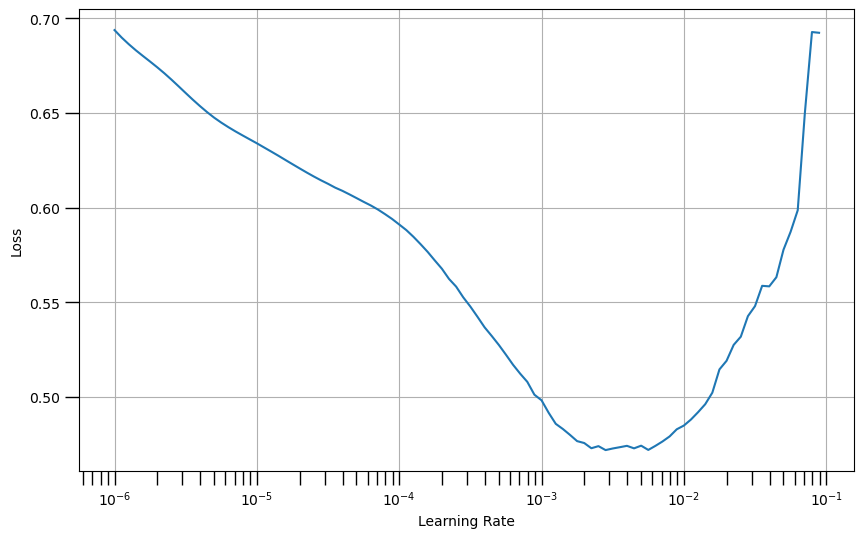

In [32]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Define the learning rate array
lrs = 1e-6 * (10 ** (np.arange(100) / 20))

# Set the figure size
fig = plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# set labels
plt.xlabel('Learning Rate')
plt.ylabel('Loss')

# Set the plot boundaries
#plt.axis([1e-8, 1e-3, 0, 100])
fig.savefig(results_dir+'/learning_rate_vs_epochs.png',\
           dpi=600,format='png',bbox_inches='tight')

plt.show()

## Training

In [41]:
#input_dim, n_ini, epochs, batch_size,  = int(df_wo.shape[-1])-1, 64, 1000, 32 # int(df_wo.shape[-1]), 
learning_rate = ['nonvarying', 3e-3]
validation_split = 0
epochs = 1000

# Saving hyperparameters
neural_network_config = {
    'hyperparameters': {
        'learning_rate': learning_rate[1],
        'epochs': epochs,
        'batch_size': batch_size ,
        'regularization': regularization,
    },
    'layers': config_1
}

# Specify the file path for saving the JSON configuration
file_path = results_dir + '/neural_network_config.json'

with open(file_path, 'w') as f:
    json.dump(neural_network_config, f, indent=4)

nn_model, history = train_NN(config_1, X_train_wo, y_train_wo, input_dim, n_ini, epochs, batch_size, validation_split, learning_rate)

# Save the model
nn_model.save(results_dir+'/model')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

INFO:tensorflow:Assets written to: /home/hasi/Documents/data science/projects/diabetes/Main/diabetes-ucidata-1/experiments/mlruns/run_2024-03-19_14-07-19/model/assets


INFO:tensorflow:Assets written to: /home/hasi/Documents/data science/projects/diabetes/Main/diabetes-ucidata-1/experiments/mlruns/run_2024-03-19_14-07-19/model/assets


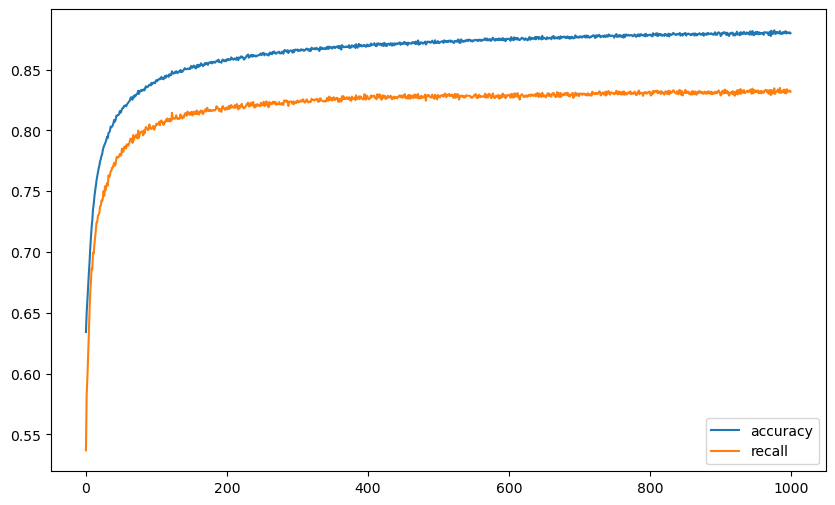

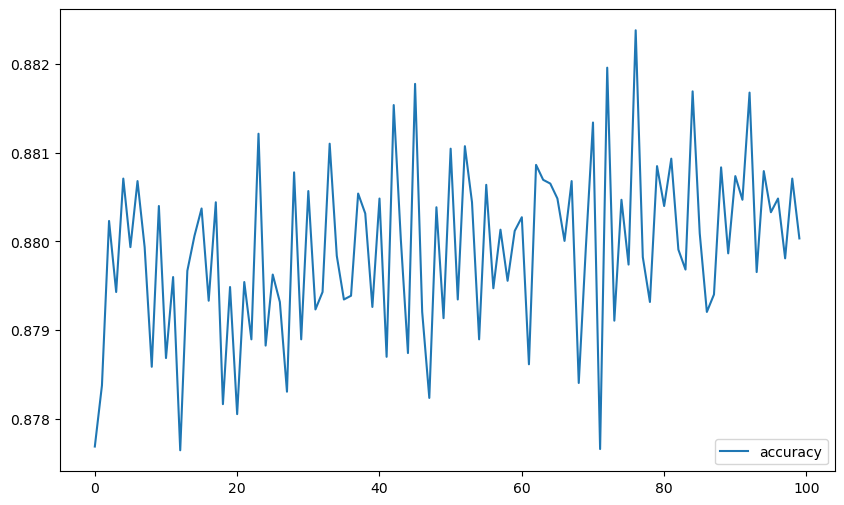

In [42]:
# Plotting the loss, accuracy and recall
loss = history.history['loss']
accuracy = history.history['accuracy']
recall = history.history['recall']

fig = plt.figure(figsize=(10, 6))

plt.plot(accuracy, label='accuracy')
plt.plot(recall, label='recall')
#plt.plot(loss, label='loss')
plt.legend(loc='lower right')

fig.savefig(results_dir+'/regl2-accuracy_recall_optimizedlr.png',\
           dpi=600,format='png',bbox_inches='tight')

plt.show()

# Zoomed-in plot
fig = plt.figure(figsize=(10, 6))

plt.plot(accuracy[int(0.9*epochs):], label='accuracy')
#plt.plot(recall[200:], label='recall')
#plt.plot(loss, label='loss')
plt.legend(loc='lower right')

fig.savefig(results_dir+'/zoom-regl2-accuracy_recall_optimizedlr.png',\
           dpi=600,format='png',bbox_inches='tight')

plt.show()

In [12]:
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix, recall_score, precision_score


predictions = nn_model.predict(X_test_wo)

new_threshold = 0.5

# Apply the new threshold to determine class labels
new_predictions = (predictions >= new_threshold).astype(int)

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test_wo, new_predictions)  # Note: use the probabilities, not the binary predictions
roc_auc = auc(fpr, tpr)

# F1 Score
f1 = f1_score(y_test_wo, new_predictions)

# Recall
recall = recall_score(y_test_wo, new_predictions)


# Confusion Matrix to derive False Positives
tn, fp, fn, tp = confusion_matrix(y_test_wo, new_predictions).ravel()

# Output the calculated metrics
print(f"Recall: {recall}")
print(f"ROC AUC: {roc_auc}")
print(f"F1 Score: {f1}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")


# File for saving the results
results_file = os.path.join(results_dir, "results.txt")

# Assuming metrics calculations are done here

with open(results_file, "w") as file:
    
    file.write(f"ROC AUC: {roc_auc}\n")
    file.write(f"F1 Score: {f1}\n")
    file.write(f"Recall: {recall}\n")
    #file.write(f"Accuracy: {accuracy}\n")
    file.write(f"True Negatives: {tn}\n")
    file.write(f"False Positives: {fp}\n")
    file.write(f"False Negatives: {fn}\n")
    file.write(f"True Positives: {tp}\n")

print(f"Results saved to {results_file}")

171/955 [====>.........................] - ETA: 0s

2024-03-19 13:11:11.184436: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 601807360 exceeds 10% of free system memory.


955/955 [==============================] - 1s 608us/step
Recall: 0.5956222016914221
ROC AUC: 0.577050422797227
F1 Score: 0.5640162858777213
False Positives: 7267
False Negatives: 5690
Results saved to /home/hasi/Documents/data science/projects/diabetes/Main/diabetes-ucidata-1/experiments/mlruns/run_2024-03-19_12-04-27/results.txt


# Performance Metrics Evaluation

In [9]:
from tensorflow.keras.models import load_model

# Load the model
results_dir = '/home/hasi/Documents/data science/projects/diabetes/Main/diabetes-ucidata-1/experiments/mlruns/run_2024-03-19_12-04-27/'
loaded_model = load_model(results_dir + 'model')

In [43]:
loaded_model = nn_model

In [40]:
predictions.flatten().size, y_test_wo.size

(30530, 30530)

955/955 [==============================] - 1s 624us/step


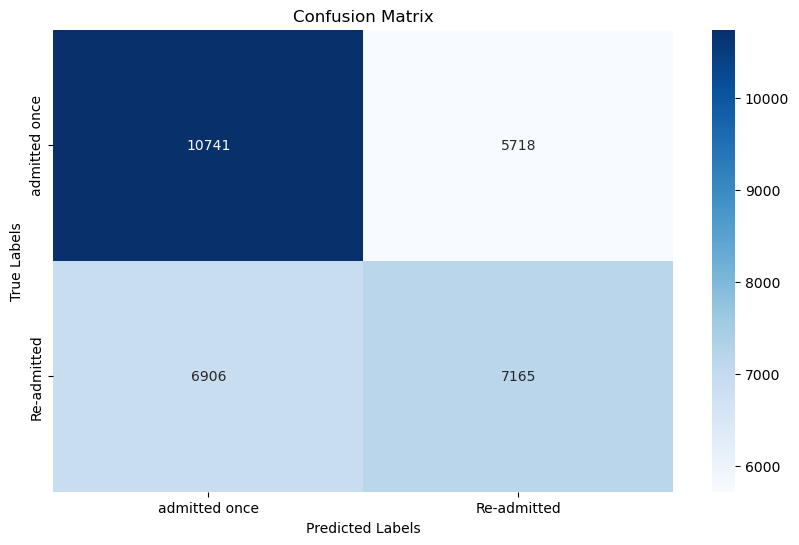

In [44]:
# Assuming you have y_test_wo and predictions as before
from sklearn.metrics import confusion_matrix

new_threshold = 0.5
predictions = loaded_model.predict(X_test_wo)

new_predictions = (predictions >= new_threshold).astype(int)

class_names = ['admitted once','Re-admitted']

cm = confusion_matrix(y_test_wo, new_predictions.flatten())

# Plotting with seaborn for a nicer look
fig = plt.figure(figsize=(10, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

fig.savefig(results_dir+'/confusion-matrix.png',\
           dpi=600,format='png',bbox_inches='tight')

plt.show()

955/955 [==============================] - 1s 583us/step


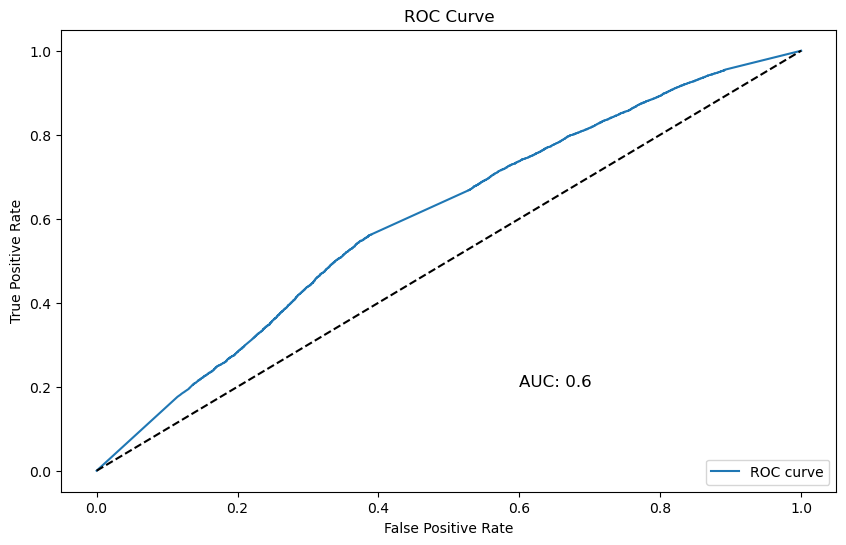

In [45]:
fig = plot_roc(loaded_model, X_test_wo, y_test_wo)
fig.savefig(results_dir+'/roc-curve.png',\
           dpi=600,format='png',bbox_inches='tight')

## Finding the optimum threshold

In [39]:
# Finding the optimal threshold (th)
th, th2 = optimal_threshold(loaded_model, X_test_wo, y_test_wo)
metr, recall, precision, f1 = metrics(loaded_model, X_test_wo, y_test_wo, th)
tn, fp, fn, tp = metr.ravel()

# False Negative Rate
fnr = fn / (tp + fn)

# File for saving the results
results_file = os.path.join(results_dir, "results.txt")

# Assuming metrics calculations are done here

with open(results_file, "w") as file:
    
    #file.write(f"ROC AUC: {roc_auc}\n")
    file.write(f"F1 Score: {f1}\n")
    file.write(f"Recall: {recall}\n")
    file.write(f"FNR: {fnr}\n")
    #file.write(f"Accuracy: {accuracy}\n")

print(f"Results saved to {results_file}")


955/955 [==============================] - 1s 626us/step
Results saved to /home/hasi/Documents/data science/projects/diabetes/Main/diabetes-ucidata-1/experiments/mlruns/run_2024-03-19_14-07-19/results.txt


In [40]:
recall, precision, f1

(0.6489233174614455, 0.5557855012477936, 0.5987540983606557)

In [10]:
from sklearn.metrics import roc_curve
import numpy as np


predictions = loaded_model.predict(X_test_wo)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_wo, predictions)

# Define a simple function to balance TPR (Recall) and 1 - FPR (Specificity)
def find_optimal_threshold(fpr, tpr, thresholds):
    # Example: maximize the sum of TPR and 1 - FPR
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold, optimal_idx

optimal_threshold, optimal_idx = find_optimal_threshold(fpr, tpr, thresholds)

print("Optimal Threshold:", optimal_threshold)

216/955 [=====>........................] - ETA: 0s

2024-03-18 10:59:35.614071: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 601807360 exceeds 10% of free system memory.


955/955 [==============================] - 1s 667us/step
Optimal Threshold: 0.43922043


In [12]:
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix, recall_score, precision_score

new_threshold = optimal_threshold

# Apply the new threshold to determine class labels
new_predictions = (predictions >= new_threshold).astype(int)

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test_wo, new_predictions)  # Note: use the probabilities, not the binary predictions
roc_auc = auc(fpr, tpr)

# F1 Score
f1 = f1_score(y_test_wo, new_predictions)

# Recall
recall = recall_score(y_test_wo, new_predictions)


# Confusion Matrix to derive False Positives
tn, fp, fn, tp = confusion_matrix(y_test_wo, new_predictions).ravel()

# Output the calculated metrics
print(f"Recall: {recall}")
print(f"ROC AUC: {roc_auc}")
print(f"F1 Score: {f1}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

Recall: 0.6382630943074409
ROC AUC: 0.6402020860685999
F1 Score: 0.6206205514477231
False Positives: 5890
False Negatives: 5090


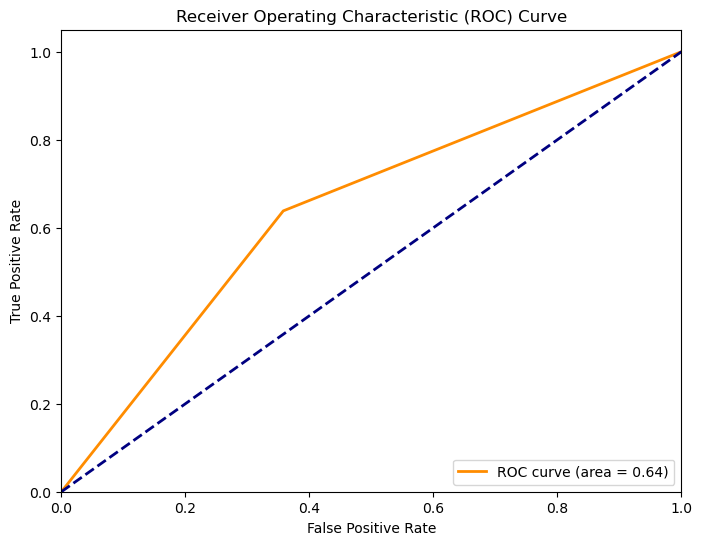

In [14]:
# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [14]:
from sklearn_evaluation.plot import ConfusionMatrix
ConfusionMatrix(y_test_wo, predictions)

TypeError: too many positional arguments

In [21]:
predictions[:,0].size

30530

In [11]:
config_1 = [(32, 'relu')]
input_dim, n_ini, epochs, batch_size, validation_split, learning_rate = int(df_wo.shape[-1])-1, 16, 100, 32, 0.2, 0.001 # int(df_wo.shape[-1]), 

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(30, input_dim=input_dim, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1, activation='sigmoid'),
  #tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 30)                73950     
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 74271 (290.12 KB)
Trainable params: 74271 (290.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Set the training parameters
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Recall

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=learning_rate))

# Train the model
#model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
history = model.fit(X_train_wo, y_train_wo, batch_size=10, epochs=epochs)

Epoch 1/100


2024-03-14 09:13:36.714110: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1404204032 exceeds 10% of free system memory.


7124/7124 [==============================] - 11s 2ms/step - loss: 0.6319 - accuracy: 0.6374
Epoch 2/100
7124/7124 [==============================] - 11s 2ms/step - loss: 0.6140 - accuracy: 0.6529
Epoch 3/100
7124/7124 [==============================] - 11s 2ms/step - loss: 0.6049 - accuracy: 0.6621
Epoch 4/100
7124/7124 [==============================] - 11s 2ms/step - loss: 0.5956 - accuracy: 0.6710
Epoch 5/100
7124/7124 [==============================] - 11s 2ms/step - loss: 0.5850 - accuracy: 0.6820
Epoch 6/100
7124/7124 [==============================] - 11s 2ms/step - loss: 0.5755 - accuracy: 0.6891
Epoch 7/100
7124/7124 [==============================] - 11s 2ms/step - loss: 0.5649 - accuracy: 0.6968
Epoch 8/100
7124/7124 [==============================] - 11s 1ms/step - loss: 0.5555 - accuracy: 0.7065
Epoch 9/100
7124/7124 [==============================] - 11s 1ms/step - loss: 0.5458 - accuracy: 0.7141
Epoch 10/100
7124/7124 [==============================] - 11s 2ms/step - los

In [8]:
# train Logistic Regression model
logreg= train_Logistic(X_train_wo, y_train_wo, max_iter=2000)

In [13]:
from src.features.feature_importance import feature_importance_logreg
imp = feature_importance_logreg(logreg, X_train_wo)

ImportError: cannot import name 'feature_importance_logreg' from 'src.features' (unknown location)

In [18]:
from src.features.feature_importance import pick_top_k_features
pick_top_k_features(X_train_wo, imp, 1000)

NameError: name 'X_train_wo' is not defined

In [19]:
from src.models.DecisionTree import train_DecisionTree
from src.features.feature_importance import feature_importance_other, pick_top_k_features

In [11]:
data = label_and_one_hot_encode(load_data())

/home/hasi/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [12]:
# split the data into train and test
X_train, X_test, y_train, y_test = split_data(data, "readmitted")

# train Decision Tree model
dtree = train_DecisionTree(X_train, y_train, max_depth=10)

NameError: name 'train_DecisionTree' is not defined

In [11]:
evaluate_model(dtree, X_train, X_test, y_train, y_test)

Train accuracy:  0.6564939075748217
Test accuracy:  0.627644939403865


(0.6564939075748217, 0.627644939403865)

In [12]:
# feature importance
imp = feature_importance_other(dtree, X_train)

In [13]:
imp

,importance
number_inpatient,0.380512
discharge_disposition_id,0.172923
number_diagnoses,0.055411
number_emergency,0.035900
admission_source_id,0.032473
...,...
diag_2_155,0.000000
diag_2_156,0.000000
diag_2_157,0.000000
diag_2_162,0.000000


In [30]:
data = label_and_one_hot_encode(load_data())

X_train, X_test, y_train, y_test = split_data(data, "readmitted")

# pick top k features
X_train = pick_top_k_features(X_train, imp, 1000)
X_test = pick_top_k_features(X_test, imp, 1000)

In [33]:
dtree = train_DecisionTree(X_train, y_train, max_depth=15)

In [34]:
evaluate_model(dtree, X_train, X_test, y_train, y_test)

Train accuracy:  0.7086725812791286
Test accuracy:  0.6199148378643957


(0.7086725812791286, 0.6199148378643957)